In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import numpy as np
import seaborn as sns
from collections import OrderedDict
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

markerSize = 6
lineWidth = 2

systemName = "meluxina"
colors = ["#FFE599", "#CF597E", "#a37afa", "#56ba23", "#FFD700", "#089099"]# Set your custom color palette
color_map = list(map(lambda x: sns.desaturate(x,0.8),colors))
sns.set_palette(color_map)
sns.color_palette() 


[(0.9600000000000001, 0.8784313725490196, 0.64),
 (0.7654901960784313, 0.3952941176470588, 0.5113725490196079),
 (0.6572549019607844, 0.528627450980392, 0.9301960784313726),
 (0.3564705882352943, 0.6701960784313725, 0.19647058823529417),
 (0.9, 0.7745098039215687, 0.09999999999999998),
 (0.08823529411764708, 0.5149019607843135, 0.5431372549019607)]

In [2]:
def readLogFile(filename):
    df = pd.read_csv(filename, header=0, delimiter=',')
    return df.sort_values(by=['M','N','K'])

def squareDatasetLimits(df, lowerLimit, upperLimit):
    return df[
        ((df['M']*df['N']*df['K'] > lowerLimit**3)) &
        ((df['M']*df['N']*df['K'] < upperLimit**3)) &
        (df['M'] == df['N']) & (df['K'] == df['M'])
    ]

def thinToFatLimits(df):
    return df[df['K'] > df['M']]

def fatToThinLimits(df):
    return df[df['K'] < df['M']]

def initialLocationDatasetLimit(df, initialLoc):
    return df[df['DataLocation'] == initialLoc]

def sortByDimensions(df):
    return df.sort_values(by=['M', 'N', 'K'])

def getHeader(df):
    return list(df)

def groupByAverage(df):
    result = df.groupby(['Algo', 'M', 'N', 'K', 'TotalGPUs', 'DataLocation']).mean().reset_index()
    return result

def groupByTiles(df, matrixSize):
    df = df[(df['M'] == matrixSize)]
    result = df.groupby(['Algo', 'TileRows', 'TileColumns', 'TotalGPUs', 'DataLocation']).mean().reset_index()
    return result

def filterNumberOfDevices(df, numDevices):
    return df[df['TotalGPUs'] == numDevices]

def strongScalingLimits(df, matrixSize, maxDevs):
    return df[
        (df['M'] == matrixSize) &
        (df['M'] == df['N']) & (df['K'] == df['M']) &
        (df['TotalGPUs'] <= maxDevs)
    ]

def weakScalingLimits(df, sizePerDev, maxDevs):
    return df[(df['M'] == sizePerDev*df['TotalGPUs']) &
        (df['TotalGPUs'] <= maxDevs)
              ]

def scalapackDecompLimits(df):
    return df[(df['Algo'] == "cuBLASMp") | (df['Algo'] == "SLATE") | (df['Algo'] == 'Cosma(ScaLAPACK)')]

In [ ]:
# Create a large tilingDataset including every time 
dataset = pd.DataFrame()

cuBLASMp = readLogFile("marenostrumLogs/DGEMM_execution_logs-PreDistributed_GEMM-marenostrum-cuBLASMp.csv")
cuBLASMp['DataLocation'] = "devices"
cuBLASMp['PlotOrder'] = 3
dataset = pd.concat([dataset,cuBLASMp])

slate = readLogFile("marenostrumLogs/DGEMM_execution_logs-PreDistributed_GEMM-marenostrum-SLATE.csv")
slate['PlotOrder'] = 1
dataset = pd.concat([dataset,slate])

cosma = readLogFile("marenostrumLogs/DGEMM_execution_logs-PreDistributed_GEMM-marenostrum-COSMA(Optimal).csv")
cosma['PlotOrder'] = 2
dataset = pd.concat([dataset,cosma])

# paraliaSequential = readLogFile("performanceComparison/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-PARALIA_Sequential.csv")
# paraliaSequential['DataLocation'] ="devices"
# paraliaSequential['PlotOrder'] = 4

# dataset = pd.concat([dataset,paraliaSequential])

# cannon25d_nccl_tiling = readLogFile("performanceComparison/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-2.5DCANNON-cuBLAS-NCCL-wTiling.csv")
# cannon25d_nccl_tiling['PlotOrder'] = 5
# dataset = pd.concat([dataset,cannon25d_nccl_tiling])

# singleNodeParalia = readLogFile("DGEMM_execution_logs-PreDistributed_GEMM-meluxina-PARALiA.csv")
# singleNodeParalia['DataLocation'] ="devices"
# singleNodeParalia['Algo'] = "PARALiA-Sequential"
# singleNodeParalia['PlotOrder'] = 4
# dataset = pd.concat([dataset,singleNodeParalia])


dataset = groupByAverage(dataset)
dataset['Performance (Tflops)'] = dataset['GFlops']/1024

# Filter Datasets for plots
squareDataset = squareDatasetLimits(dataset, 4095, 65537)
thinToFatDataset = thinToFatLimits(dataset)
fatToThinDataset = fatToThinLimits(dataset)

squareDataset['shape'] = 'Square\n( M = N = K )'
thinToFatDataset['shape'] = 'Thin-Fat\n( M = N << K )'
fatToThinDataset['shape'] = 'Fat-thin\n( M = N >> K )'

# Save Datasets for analysis 
squareDataset.to_csv("squareDataset.csv", index=False)
thinToFatDataset.to_csv("thinToFatDataset.csv", index=False)
fatToThinDataset.to_csv("fatToThinDataset.csv", index=False)

586    141920.565594
582    143505.131643
399     47288.206949
424     69500.917820
585    284667.163588
           ...      
494    260276.347057
488    249624.096522
493    135845.613188
530    279219.712794
491    253430.370215
Name: GFlops, Length: 74, dtype: float64


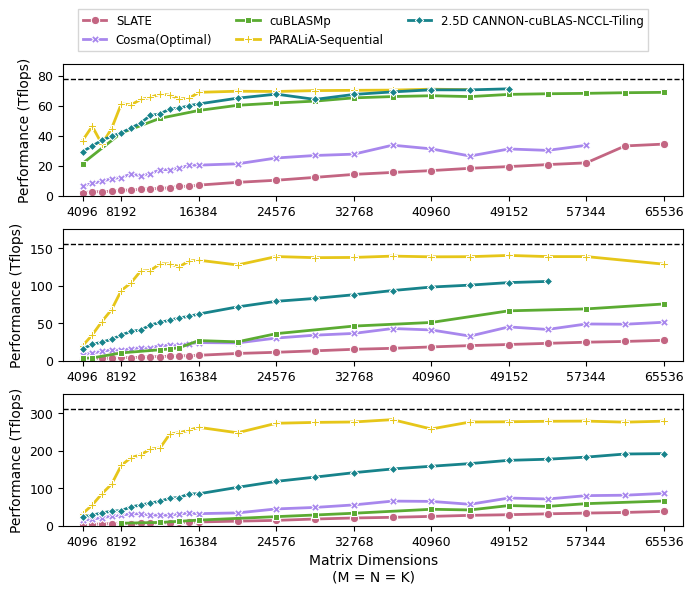

In [8]:
sns.set_palette(color_map[1:])
sns.color_palette()
squareDataset.sort_values(inplace = True, by = ['PlotOrder'])
squareDataset.to_csv("test.csv")

print(squareDataset[squareDataset['Algo'] == 'PARALiA-Sequential']['GFlops'])

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6))

sns.lineplot(data=filterNumberOfDevices(squareDataset, 4), x='K', y = 'Performance (Tflops)', hue='Algo', ax=axes[0], style='Algo', markers = True, markersize = 6, linewidth = 2, dashes=False)
sns.lineplot(data=filterNumberOfDevices(squareDataset, 8), x='K', y = 'Performance (Tflops)', hue='Algo', ax=axes[1], style='Algo', markers = True, markersize = 6,  linewidth = 2, dashes=False, legend=False)
sns.lineplot(data=filterNumberOfDevices(squareDataset, 16), x='K', y = 'Performance (Tflops)', hue='Algo', ax=axes[2], style='Algo', markers = True, markersize = 6, linewidth = 2, dashes=False, legend=False)

for ax, numDevices in zip(axes, [4,8,16]):
    ax.axhline(y = 19.5*numDevices, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylim([0, numDevices*19.5 + 10*(numDevices/4)])
    # ax.set_title(f'Number Of Nodes: {int(numDevices/4)}', fontsize=8)
    ax.set_xlabel('')
    ax.set_xlim([2048, 2**16+2048])
    ax.set_xticks([8192+x*8192 for x in range(0,8)] + [4096])
    ax.tick_params(labelsize=9)

plt.grid(False)
axes[2].set_xlabel('Matrix Dimensions\n(M = N = K)', fontsize=10)
plt.subplots_adjust(hspace=0.25)
axes[0].get_legend().remove()

fig.legend(loc = 'upper center', fontsize = 8.5, fancybox = False, ncol = 3, bbox_to_anchor=(0.5,0.98))
plt.savefig(f"plots/{systemName}-PreDistributed-DGEMM-PerformanceComparison.png")

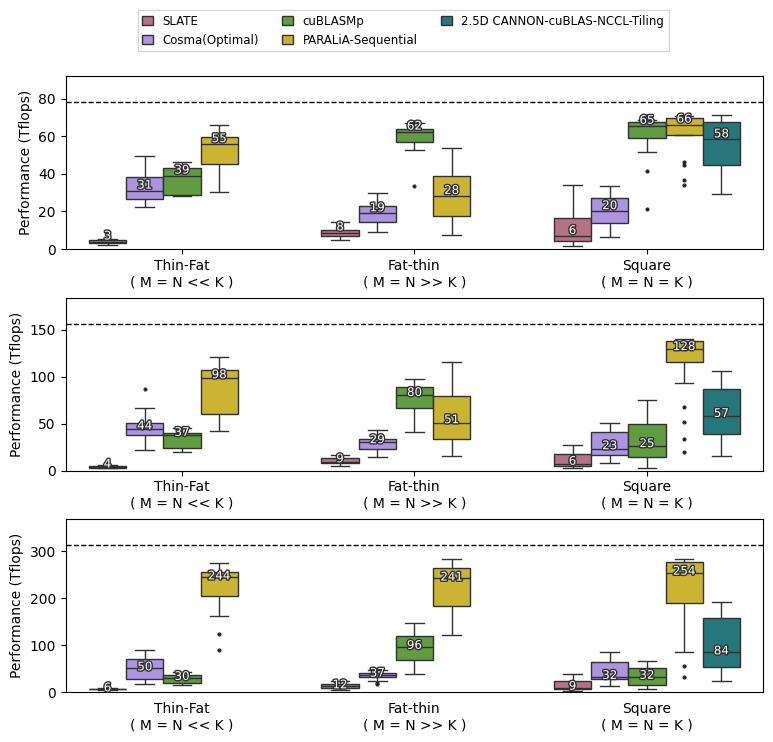

In [5]:
#------------- SIMPLE PERFORMANCE/ SOTA COMPARISON PLOT BOXPLOT --------------------#
def add_median_labels(ax: plt.Axes, offset: int, fmt: str = "d") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y + offset, f'{int(value):{fmt}}', ha='center', va='center',
                       color='white', fontsize = 8.5) #fontweight='bold', 
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=median.get_color()),
            path_effects.Normal(),
        ])

dataset_plotlist = pd.concat([squareDataset,fatToThinDataset,thinToFatDataset])
dataset_plotlist.sort_values(inplace = True, by = ['PlotOrder'])

flierprops = dict(markerfacecolor='k', markersize=2,
            linestyle='none')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9,8))

axout1 = sns.boxplot(data=filterNumberOfDevices(dataset_plotlist, 4), x = 'shape', hue = 'Algo', y = 'Performance (Tflops)', ax=axes[0], flierprops=flierprops)
axout2 = sns.boxplot(data=filterNumberOfDevices(dataset_plotlist, 8), x = 'shape', hue = 'Algo', y = 'Performance (Tflops)', ax=axes[1], flierprops=flierprops, legend=False)
axout3 = sns.boxplot(data=filterNumberOfDevices(dataset_plotlist, 16), x = 'shape', hue = 'Algo', y = 'Performance (Tflops)', ax=axes[2], flierprops=flierprops, legend=False)

for ax, numDevs in zip(axes, [4,8,16]):
    ax.axhline(y = 19.5*numDevs, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_xlabel('')
    # ax.set_title(f'Number Of Nodes: {int(numDevs/4)}', fontsize=8)
    ax.set_ylim([0,23*numDevs])


plt.tick_params(bottom = False) 
add_median_labels(axout1, 3)
add_median_labels(axout2, 3)
add_median_labels(axout3, 3)
axes[0].get_legend().remove()

fig.legend(loc = 'upper center',#title="Model",  # Title for the legend
    fontsize=8.5, fancybox = False, ncol=3, handlelength=0.9, bbox_to_anchor=(0.5,0.97))
plt.subplots_adjust(hspace=0.28)
machineName = "meluxina"
fig.savefig(f'plots/{machineName}-PreDistributed-DGEMM-BoxPlot.png') 

   TotalGPUs  TheorMax
0          4      78.0
1          8     156.0
2         16     312.0
3         24     468.0
4         32     624.0
5         40     780.0
6         48     936.0
7         64    1248.0


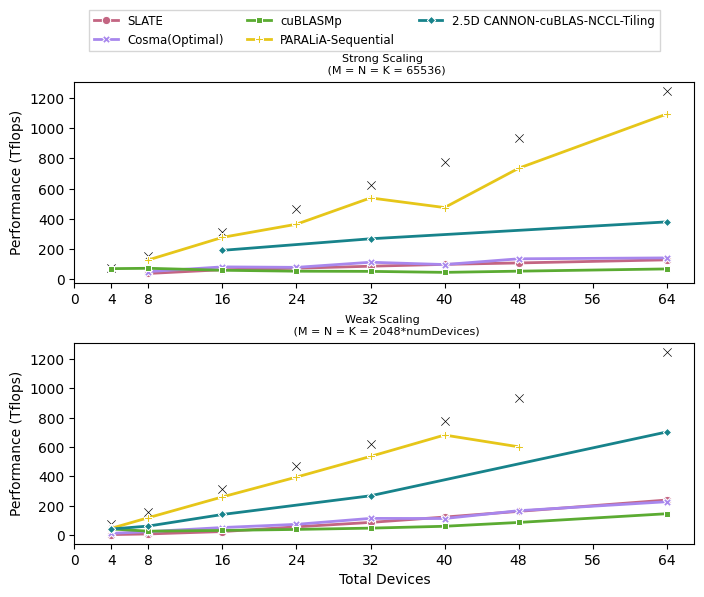

In [6]:
#------------- DATA SETUP --------------------#
strongScalingDataset = pd.DataFrame()
cuBLASMp = readLogFile("strongScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-cuBLASMp.csv")
cuBLASMp['DataLocation'] = "devices"
cuBLASMp['PlotOrder'] = 3
strongScalingDataset = pd.concat([strongScalingDataset,cuBLASMp])

slate = readLogFile("strongScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-SLATE.csv")
slate['PlotOrder'] = 1
strongScalingDataset = pd.concat([strongScalingDataset,slate])

cosma = readLogFile("strongScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-COSMA(Optimal).csv")
cosma['PlotOrder'] = 2
strongScalingDataset = pd.concat([strongScalingDataset,cosma])

paraliaSequential = readLogFile("strongScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-PARALIA_Sequential.csv")
paraliaSequential['DataLocation'] ="devices"
paraliaSequential['PlotOrder'] = 4
strongScalingDataset = pd.concat([strongScalingDataset,paraliaSequential])

cannon25d_nccl_tiling = readLogFile("strongScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-2.5DCANNON-cuBLAS-NCCL-wTiling.csv")
cannon25d_nccl_tiling['PlotOrder'] = 5
strongScalingDataset = pd.concat([strongScalingDataset,cannon25d_nccl_tiling])

strongScalingDataset = groupByAverage(strongScalingDataset)
strongScalingDataset = strongScalingLimits(strongScalingDataset, 2**16, 64)
strongScalingDataset['Performance (Tflops)'] = strongScalingDataset['GFlops']/1024

strongScalingDataset.sort_values(inplace=True, by='PlotOrder')

weakScalingDataset = pd.DataFrame()
cuBLASMp = readLogFile("weakScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-cuBLASMp.csv")
cuBLASMp['DataLocation'] = "devices"
cuBLASMp['PlotOrder'] = 3
weakScalingDataset = pd.concat([weakScalingDataset,cuBLASMp])

slate = readLogFile("weakScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-SLATE.csv")
slate['PlotOrder'] = 1
weakScalingDataset = pd.concat([weakScalingDataset,slate])

cosma = readLogFile("weakScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-COSMA(Optimal).csv")
cosma['PlotOrder'] = 2
weakScalingDataset = pd.concat([weakScalingDataset,cosma])

paraliaSequential = readLogFile("weakScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-PARALIA_Sequential.csv")
paraliaSequential['DataLocation'] ="devices"
paraliaSequential['PlotOrder'] = 4
weakScalingDataset = pd.concat([weakScalingDataset,paraliaSequential])

cannon25d_nccl_tiling = readLogFile("weakScaling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-2.5DCANNON-cuBLAS-NCCL-wTiling.csv")
cannon25d_nccl_tiling['PlotOrder'] = 5
weakScalingDataset = pd.concat([weakScalingDataset,cannon25d_nccl_tiling])

weakScalingDataset = groupByAverage(weakScalingDataset)
weakScalingDataset['Performance (Tflops)'] = weakScalingDataset['GFlops']/1024
weakScalingDataset = weakScalingLimits(weakScalingDataset, 2048, 64)
weakScalingDataset.sort_values(inplace=True, by='PlotOrder')

nodeList = [1,2,4,6,8,10,12,16]
devList = [x*4 for x in nodeList]
maxlist = [x*4*19.5 for x in nodeList]

maxFrame = pd.DataFrame()
maxFrame['TotalGPUs'] = devList
maxFrame['TheorMax'] = maxlist
print(maxFrame)

# --------------------------- ACTUAL PLOT - WEAK SCALING - (M=N=K=2048*numDevices) - STRONG SCALING - (M=N=K=2**16)
sns.set_palette(color_map[1:])

# sns.lineplot(data=filterNumberOfDevices(squareDataset, 4), x='K', y = 'Performance (Tflops)', hue='Algo', ax=axes[0], style='Algo', markers = True, markersize = 5, linewidth = 2, dashes=False)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (8,6))
sns.lineplot(data=strongScalingDataset, x='TotalGPUs', y = 'Performance (Tflops)', hue='Algo', ax=axes[0], style='Algo', markers = True, markersize = 6, linewidth = 2, dashes=False)
sns.lineplot(data=weakScalingDataset, x='TotalGPUs', y = 'Performance (Tflops)', hue='Algo', ax=axes[1],  style='Algo', markers = True, markersize = 6, linewidth = 2,  dashes=False, legend=False)
sns.scatterplot(data=maxFrame, x='TotalGPUs', y ='TheorMax', ax=axes[0], marker='x', color='k')
sns.scatterplot(data=maxFrame, x='TotalGPUs', y ='TheorMax', ax=axes[1], marker='x', color='k')

for ax in axes:
    ax.set_xlabel('')
    ax.set_xticks([8*x for x in range(0,9)] + [4])


axes[1].set_xlabel('Total Devices', fontsize=10)
axes[0].set_title(f"Strong Scaling \n (M = N = K = 65536)", fontsize=8)
axes[1].set_title(f"Weak Scaling \n (M = N = K = 2048*numDevices)", fontsize=8)

axes[0].get_legend().remove()
plt.subplots_adjust(hspace=0.3)
fig.legend(loc = 'upper center', fontsize = 8.5, fancybox = False, ncol = 3, bbox_to_anchor = (0.5, 1.01))
systemName="meluxina"
fig.savefig(f'plots/{systemName}-PreDistributed-DGEMM-Scaling.png')